In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers

# Model

In [ ]:
tf.__version__

'2.18.0'

## Patch Extraction

In [ ]:
# This defines a new class Patches that inherits from layers.Layer, typically used in TensorFlow to create custom layers.
class Patches(layers.Layer):
  def __init__(self, patch_size):
    # Ensure proper initialization
    super(Patches, self).__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images= images,
        sizes = [1, self.patch_size, self.patch_size, 1],
        strides = [1, self.patch_size, self.patch_size, 1],
        # The dilation rates for the height and width dimensions
        rates = [1, 1, 1, 1],
        padding = 'VALID',
    )
    dim = patches.shape[-1]
    patches = tf.reshape(patches, (batch_size, -1, dim))
    print('patches.shape: {}'.format(patches.shape))

    return patches

image.shape: (1, 300, 300, 3)
patches.shape: (1, 9, 30000)
visual_patches.shape: (9, 100, 100, 3)


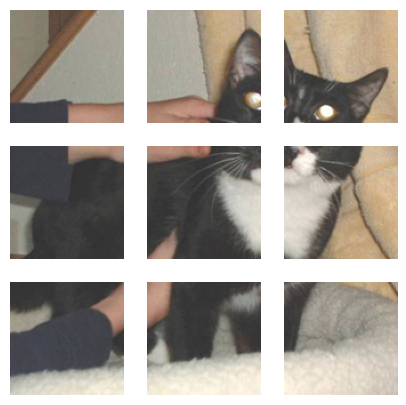

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Load your image
image_path = "/content/cat.2000.jpg"
image = Image.open(image_path)
image = image.resize((300, 300))  # Resize to 64x64 if necessary
image = np.array(image) / 255.0  # Normalize to [0, 1]
# This is necessary for compatibility with TensorFlow's input requirements
image = np.expand_dims(image, axis=0)  # Add batch dimension
print('image.shape: {}'.format(image.shape))

# Define patch size
patch_size = 100

# Initialize the Patches layer with a patch size
patches_layer = Patches(patch_size)

# Apply the patches layer to the sample images
patches = patches_layer(image)

visual_patches = np.squeeze(patches, axis=0)  # Remove the first dimension
visual_patches = tf.reshape(visual_patches, (-1, patch_size, patch_size, 3))
print('visual_patches.shape: {}'.format(visual_patches.shape))

# Plot the patches
fig, axes = plt.subplots(image.shape[1] // patch_size, image.shape[2] // patch_size, figsize=(5, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(tf.reshape(patches, (-1, patch_size, patch_size, 3))[i])
    ax.axis("off")

plt.show()

## MLP Block (Token Mixing & Channel Mixing)

In [ ]:
class MLPBlock(layers.Layer):
  def __init__(self, S, C, DS, DC):
    super(MLPBlock, self).__init__()
    self.layerNorm1 = layers.LayerNormalization()
    self.layerNorm2 = layers.LayerNormalization()
    w_init = tf.random_normal_initializer()
    self.DS = DS
    self.DC = DC
    self.W1 = tf.Variable(
            initial_value=w_init(shape=(S, DS), dtype="float32"),
            trainable=True,
    )
    self.W2 = tf.Variable(
            initial_value=w_init(shape=(DS, S), dtype="float32"),
            trainable=True,
    )
    self.W3 = tf.Variable(
            initial_value=w_init(shape=(C, DC), dtype="float32"),
            trainable=True,
    )
    self.W4 = tf.Variable(
            initial_value=w_init(shape=(DC, C), dtype="float32"),
            trainable=True,
    )

  def call(self, X):
    # patches (..., S, C)
    #print('X.shape: {}'.format(X.shape))
    batch_size, S, C = X.shape

    # Token-mixing
    # (..., C, S)
    X_T = tf.transpose(self.layerNorm1(X), perm=(0, 2, 1))

    # assert X_T.shape == (batch_size, C, S), 'X_T.shape: {}'.format(X_T.shape)

    W1X = tf.matmul(X_T, self.W1) # (..., C, S) . (S, DS) = (..., C, DS)

    # (..., C, DS) . (DS, S) == (..., C, S)
    # (..., C, S). T == (..., S, C)
    # (..., S, C) + (..., S, C) = (..., S, C)
    U = tf.transpose(tf.matmul(tf.nn.gelu(W1X), self.W2), perm=(0, 2, 1)) + X # skip connection

    # Channel-minxing

    W3U = tf.matmul(self.layerNorm2(U), self.W3) # (...,S, C) . (C, DC) = (..., S, DC)

    Y = tf.matmul(tf.nn.gelu(W3U), self.W4) + U  # (..., S, DC) . (..., DC, C) + (..., S, C) = (..., S, C) # skip connection

    return Y


MLP Block Output Shape: (1, 9, 30000)


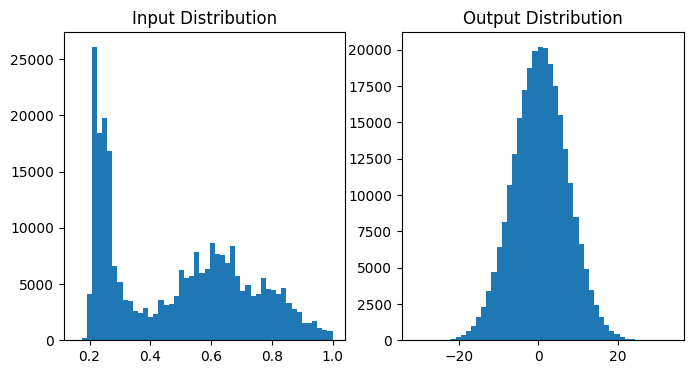

In [ ]:
# Test with random input
S, C, DS, DC = 9, 30000, 256, 512
mlp_block = MLPBlock(S, C, DS, DC)

output = mlp_block(patches)
print("MLP Block Output Shape:", output.shape)  # Should match input shape

# Plot before/after distributions
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Input Distribution")
plt.hist(patches.numpy().flatten(), bins=50)

plt.subplot(1, 2, 2)
plt.title("Output Distribution")
plt.hist(output.numpy().flatten(), bins=50)

plt.show()

In [ ]:
"""
When using @tf.function (or if running inside Model.fit() or Model.predict()), TensorFlow traces the function once before execution to convert it into a computation graph.
As a result, call() might run twice:
Once for tracing (shape inference).
Once for actual execution.
"""

'\nWhen using @tf.function (or if running inside Model.fit() or Model.predict()), TensorFlow traces the function once before execution to convert it into a computation graph.\nAs a result, call() might run twice:\nOnce for tracing (shape inference).\nOnce for actual execution.\n'

## Full MLP-Mixer Model

In [ ]:
class MLPMixer(models.Model):
  def __init__(self, patch_size, S, C, DS, DC, num_of_mlp_blocks, image_size, batch_size, num_classes):
    super(MLPMixer, self).__init__()
    self.projection = layers.Dense(C)
    self.mlpBlocks = [MLPBlock(S, C, DS, DC) for _ in range(num_of_mlp_blocks)]
    self.patches_layer = Patches(patch_size)

    self.batch_size = batch_size
    self.patch_size = patch_size
    self.S = S
    self.C = C
    self.DS = DS
    self.DC = DC
    self.image_size = image_size
    self.num_classes = num_classes

    self.classificationLayer = models.Sequential([
          layers.GlobalAveragePooling1D(),
          layers.Dropout(0.2),
          layers.Dense(num_classes, activation='softmax')
    ])

  def call(self, images):
    # input
    # images shape: (batch_size, image_size, image_size, 3) = (32, 64, 64, 3)

    batch_size = images.shape[0]

    #augumented_images = self.data_augmentation(images)

    # assert augumented_images.shape == (batch_size, self.image_size, self.image_size, 3)

    # patches shape: (batch_size, S, 3 * patch_size ** 2)
    X = self.patches_layer(images)

    # Per-patch Fully-connected
    # X shape: (batch_size, S, C)
    X = self.projection(X)

    # assert X.shape == (batch_size, self.S, self.C)
    for block in self.mlpBlocks:
      X = block(X)

    # assert X.shape == (batch_size, self.S, self.C)

    # out shape: (batch_size, C)
    out = self.classificationLayer(X)

    print('output.shape: {}'.format(out.shape))
    assert out.shape == (batch_size, self.num_classes), "Oops, wrong output shape"

    return out

In [ ]:
# Test the Model
batch_size = 32
image_size = 300
patch_size = 100
S = (image_size // patch_size) ** 2  # Number of patches
C = 128  # Embedding dimension
DS = 256  # MLP hidden size for spatial mixing
DC = 512  # MLP hidden size for channel mixing
num_of_mlp_blocks = 4
num_classes = 10

from PIL import Image

# Load your image
image_path = "/content/cat.2000.jpg"
image = Image.open(image_path)
image = image.resize((300, 300))  # Resize to 64x64 if necessary
image = np.array(image) / 255.0  # Normalize to [0, 1]
# This is necessary for compatibility with TensorFlow's input requirements
image = np.expand_dims(image, axis=0)  # Add batch dimension
print('image.shape: {}'.format(image.shape))
# Create a sample batch of images (batch_size, image_size, image_size, 3)
test_images = image

# Initialize and Test MLPMixer

model = MLPMixer(patch_size, S, C, DS, DC, num_of_mlp_blocks, image_size, batch_size, num_classes)
#model.adapt_normalization(test_images)
output = model(test_images)

image.shape: (1, 300, 300, 3)
patches.shape: (1, 9, 30000)
output.shape: (1, 10)
patches.shape: (1, 9, 30000)
output.shape: (1, 10)


# Load source

In [ ]:
!pip install tensorflow_addons

In [ ]:
"""
Features of tensorflow_addons
Layers: Additional layers like GroupNormalization, WeightNormalization, and MaxUnpooling2D.
Optimizers: AdamW, NovoGrad, Rectified Adam (RAdam), Lookahead, etc.
Loss Functions: Triplet Loss, Huber Loss, Focal Loss.
Metrics: Cohen’s Kappa, F1 score, Hamming loss, etc.
Regularization: Spectral normalization, Stochastic weight averaging.
"""

In [ ]:
cd mlp-mixer/

/content/mlp-mixer


In [ ]:
train_folder = './data/cats_and_dogs_filtered/train'
valid_folder = './data/cats_and_dogs_filtered/validation'

!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O ./cats_and_dogs_filtered.zip

--2025-02-21 04:24:01--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.207, 64.233.187.207, 64.233.188.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M  20.8MB/s    in 3.3s    

2025-02-21 04:24:05 (19.7 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
# Unzip the data
main_folder = './data'
!unzip -q cats_and_dogs_filtered.zip -d $main_folder

# Train

In [ ]:
cd /content/drive/MyDrive/mlp-mixer-main

/content/drive/MyDrive/mlp-mixer-main


In [ ]:
%ls

cats_and_dogs_filtered.zip  images/          model.py      README.md
data/                       mlp-mixer-main/  predict.py    train.py
environment.yml             model/           __pycache__/  Untitled.ipynb


In [ ]:
train_folder = './data/cats_and_dogs_filtered/train'
valid_folder = './data/cats_and_dogs_filtered/validation'

In [ ]:
!python train.py --epochs 100 --num-classes 2 --patch-size 50 --train-folder $train_folder --valid-folder $valid_folder

2025-02-23 12:44:21.887275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740314661.992007   15531 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740314662.022689   15531 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 12:44:22.118132: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
---------------------Welcome to ProtonX MLP Mixer-------------------
Github: bangoc123
Email: protonxai@gmail.com
-----------

----

In [ ]:
!git clone https://github.com/bangoc123/mlp-mixer

Cloning into 'mlp-mixer'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 59 (delta 27), reused 45 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 260.08 KiB | 9.63 MiB/s, done.
Resolving deltas: 100% (27/27), done.


# Self-Build

In [ ]:
cd /content/drive/MyDrive/mlp-mixer-main

/content/drive/MyDrive/mlp-mixer-main


In [ ]:
import os
from PIL import Image

# Define the dataset path
dataset_path = "data/cats_and_dogs_filtered"  # Change if needed
folders = ["train", "validation"]

# Store image size information
size_info = {}

for folder in folders:
    folder_path = os.path.join(dataset_path, folder)
    total_images = 0
    print(f"\nProcessing folder: {folder}")

    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                total_images += 1
                file_path = os.path.join(root, file)

                # Get image size
                with Image.open(file_path) as img:
                    size = img.size  # (width, height)

                # Store image size information
                if size not in size_info:
                    size_info[size] = []
                size_info[size].append(file_path)

    print(f"Total images in {folder}: {total_images}")

# Print image size variations
print("\nImage Size Distribution:")
for size, locations in size_info.items():
    print(f"Size {size}: {len(locations)} images")
    if len(locations) < 5:  # Print file paths if few images have this size
        for loc in locations:
            print(f" - {loc}")


Processing folder: train
Total images in train: 2000

Processing folder: validation
Total images in validation: 1000

Image Size Distribution:
Size (403, 499): 2 images
 - data/cats_and_dogs_filtered/train/cats/cat.100.jpg
 - data/cats_and_dogs_filtered/validation/dogs/dog.2236.jpg
Size (500, 374): 350 images
Size (300, 280): 1 images
 - data/cats_and_dogs_filtered/train/cats/cat.1.jpg
Size (489, 499): 3 images
 - data/cats_and_dogs_filtered/train/cats/cat.10.jpg
 - data/cats_and_dogs_filtered/train/cats/cat.447.jpg
 - data/cats_and_dogs_filtered/train/dogs/dog.602.jpg
Size (296, 200): 1 images
 - data/cats_and_dogs_filtered/train/cats/cat.101.jpg
Size (349, 343): 1 images
 - data/cats_and_dogs_filtered/train/cats/cat.102.jpg
Size (500, 386): 2 images
 - data/cats_and_dogs_filtered/train/cats/cat.103.jpg
 - data/cats_and_dogs_filtered/train/dogs/dog.14.jpg
Size (253, 399): 1 images
 - data/cats_and_dogs_filtered/train/cats/cat.104.jpg
Size (215, 174): 1 images
 - data/cats_and_dogs_fi

In [ ]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

import os

for fname in os.listdir('data/cats_and_dogs_filtered/train/cats'):
  print(fname)


cat.100.jpg
cat.0.jpg
cat.1.jpg
cat.10.jpg
cat.101.jpg
cat.102.jpg
cat.103.jpg
cat.104.jpg
cat.105.jpg
cat.106.jpg
cat.107.jpg
cat.108.jpg
cat.109.jpg
cat.110.jpg
cat.11.jpg
cat.111.jpg
cat.112.jpg
cat.113.jpg
cat.114.jpg
cat.115.jpg
cat.116.jpg
cat.117.jpg
cat.118.jpg
cat.119.jpg
cat.120.jpg
cat.12.jpg
cat.121.jpg
cat.122.jpg
cat.123.jpg
cat.124.jpg
cat.128.jpg
cat.127.jpg
cat.129.jpg
cat.126.jpg
cat.125.jpg
cat.134.jpg
cat.132.jpg
cat.135.jpg
cat.13.jpg
cat.133.jpg
cat.130.jpg
cat.131.jpg
cat.14.jpg
cat.139.jpg
cat.141.jpg
cat.137.jpg
cat.138.jpg
cat.136.jpg
cat.140.jpg
cat.143.jpg
cat.146.jpg
cat.145.jpg
cat.144.jpg
cat.142.jpg
cat.147.jpg
cat.15.jpg
cat.153.jpg
cat.149.jpg
cat.151.jpg
cat.150.jpg
cat.152.jpg
cat.148.jpg
cat.158.jpg
cat.154.jpg
cat.156.jpg
cat.159.jpg
cat.155.jpg
cat.157.jpg
cat.16.jpg
cat.160.jpg
cat.163.jpg
cat.165.jpg
cat.161.jpg
cat.162.jpg
cat.164.jpg
cat.167.jpg
cat.170.jpg
cat.166.jpg
cat.169.jpg
cat.168.jpg
cat.171.jpg
cat.17.jpg
cat.173.jpg
cat.175.jpg
cat.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import cv2

In [ ]:
"""# Load and preprocess MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train.astype("float32") / 255.0, x_test.astype("float32") / 255.0

# Reshape data to fit MLP-Mixer input (batch, height, width, channels)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)"""

In [ ]:
train_folder = './data/cats_and_dogs_filtered/train'
valid_folder = './data/cats_and_dogs_filtered/validation'

In [ ]:
# Load train images from folder
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    subset="training",
    seed=123,
    image_size=(150, 150),
    shuffle=True,
    validation_split = 0.2,
    batch_size = 32,
)

# Load Validation images from folder
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_folder,
    subset="validation",
    seed=123,
    image_size=(150, 150),
    shuffle=True,
    validation_split = 0.2,
    batch_size = 32,
)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 1000 files belonging to 2 classes.
Using 200 files for validation.


In [ ]:
class_names = train_ds.class_names  # Get class names
print("Class Names:", class_names)

Class Names: ['cats', 'dogs']


In [ ]:
# Define MLP-Mixer model
class MLPMixer(keras.Model):
    def __init__(self, image_size=28, patch_size=7, hidden_dim=128, num_classes=10, num_blocks=2):
        super().__init__()
        self.num_patches = (image_size // patch_size) ** 2
        self.projection = layers.Conv2D(hidden_dim, kernel_size=patch_size, strides=patch_size, padding='valid')
        self.flatten = layers.Reshape((self.num_patches, hidden_dim))

        self.mixer_blocks = []
        for _ in range(num_blocks):
            self.mixer_blocks.append(
                keras.Sequential([
                    layers.LayerNormalization(),
                    layers.Dense(self.num_patches, activation='gelu'),
                    layers.Dense(hidden_dim),
                    layers.LayerNormalization(),
                    layers.Dense(hidden_dim, activation='gelu'),
                    layers.Dense(hidden_dim),
                ])
            )

        self.global_pool = layers.GlobalAveragePooling1D()
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.projection(inputs)
        x = self.flatten(x)
        for mixer_block in self.mixer_blocks:
            x = x + mixer_block(x)
        x = self.global_pool(x)
        return self.classifier(x)


In [ ]:
# Instantiate and compile the model
model = MLPMixer(150, 5, 128, 2, 5)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Do Training model
history = model.fit(train_ds,
    epochs=100,
    batch_size=32,
    validation_data=val_ds,
)

from datetime import datetime
# Generate a timestamp for uniqueness
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
# Define model filename based on hyperparameters
model_filename = f"mlp_mixer_ep{100}_bs{32}_{timestamp}.keras"

# Saving model with a valid filename
model.save(os.path.join('model/mlp/', model_filename))


# Evaluate the model
model.evaluate(val_ds, verbose=2)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 184ms/step - accuracy: 0.4996 - loss: 28.1616 - val_accuracy: 0.4550 - val_loss: 1.9392
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.5198 - loss: 2.8119 - val_accuracy: 0.4350 - val_loss: 3.5209
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.5095 - loss: 2.1285 - val_accuracy: 0.5950 - val_loss: 0.6681
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.5529 - loss: 1.1507 - val_accuracy: 0.6350 - val_loss: 0.6723
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.5476 - loss: 0.9496 - val_accuracy: 0.6100 - val_loss: 0.7191
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.5469 - loss: 0.9641 - val_accuracy: 0.4650 - val_loss: 1.3096
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.5164 - loss: 1.2395 - val_accuracy: 0.6800 - val_loss: 0.6366
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.6139 - loss: 0.7446 - va

[0.6277092695236206, 0.6600000262260437]

In [ ]:
# Load class names
class_names = train_ds.class_names  # Example: ['cat', 'dog']
class_names

['cats', 'dogs']

In [ ]:
# Load test images from folder
image = tf.keras.preprocessing.image.load_img('/content/cat.2000.jpg')
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
x = tf.image.resize(
    input_arr, [150, 150]
)

predictions = model.predict(x)
print('---------------------Prediction Result: -------------------')
print('Output Softmax: {}'.format(predictions))
print('This image belongs to class: {}'.format(class_names[np.argmax(predictions, axis=1)[0]]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
---------------------Prediction Result: -------------------
Output Softmax: [[0.5659553  0.43404472]]
This image belongs to class: cats


In [ ]:
np.argmax(predictions, axis=1)

array([0])